In [1]:
from make_df import *
import nltk
from nltk.collocations import *

import pandas as pd
import string
from Trend import Trend
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from make_years import *
import numpy as np

from make_bigrams import *

from gensim.models import Word2Vec

import pickle
from collections import Counter



/home/ubuntu/.local/lib/python2.7/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")



The purpose of this notebook is zero in on interesting bigrams from 2012

In [2]:
df1 = pd.read_pickle('/dataxvdf/masterA-1128.pkl')
#df1 = get_columns_for_nlp(df1)

In [3]:
df2 = pd.read_pickle('/dataxvdf/masterB-1128.pkl')

In [4]:
df3 = pd.read_pickle('/dataxvdf/masterC-1128.pkl')

In [5]:
dfX = pd.concat([df1, df2, df3])

In [6]:
mask = dfX.post_id != 0

In [7]:
dfY = dfX[mask]

In [8]:
dfY.describe()

,post_id,month,quarter,year
count,9.124150e+05,912415.000000,912415.000000,912415.000000
mean,6.214040e+05,6.414045,2.477311,2011.767255
std,3.375512e+05,3.419922,1.108311,1.977922
min,5.001000e+03,1.000000,1.000000,2008.000000
25%,3.338835e+05,3.000000,1.000000,2010.000000
50%,6.239220e+05,6.000000,2.000000,2012.000000
75%,9.203185e+05,9.000000,3.000000,2013.000000
max,1.174999e+06,12.000000,4.000000,2016.000000


In [9]:
def make_year(df, year):
    mask = df.year == year
    return df[mask]

def make_quarter(df, year, quarter):
    year_df = make_year(df, year)
    mask = year_df.quarter == quarter
    return year_df[mask]


In [10]:
df2008 = make_year(dfY, 2008)
df2009 = make_year(dfY, 2009)
df2010 = make_year(dfY, 2010)
df2011 = make_year(dfY, 2011)
df2012 = make_year(dfY, 2012)
df2013 = make_year(dfY, 2013)
df2014 = make_year(dfY, 2014)
df2015 = make_year(dfY, 2015)
df2016 = make_year(dfY, 2016)

In [11]:
df2008 = df2008[df2008.datetime > '2008-03-01']


In [51]:
df2016.describe()

,post_id,month,quarter,year
count,2.522000e+04,25220.000000,25220.000000,25220.0
mean,1.161364e+06,5.047859,2.051983,2016.0
std,1.260016e+04,2.836569,0.949388,0.0
min,6.446490e+05,1.000000,1.000000,2016.0
25%,1.155171e+06,3.000000,1.000000,2016.0
50%,1.161793e+06,5.000000,2.000000,2016.0
75%,1.168440e+06,8.000000,3.000000,2016.0
max,1.174999e+06,11.000000,4.000000,2016.0


In [12]:
#this df will be used for plotting over time. Right now I am looking at 2009-2013.
#2014-2016 data has been set aside for validation
dfZ = pd.concat([df2009, df2010, df2011, df2012, df2013, df2014, df2015, df2016])

At this point, I have collected all my data together into a group of dataframes, segmented by year. I will now begin the process of bigramifying my data.

Step 1: create a model based on all the data we have. Thankfully I've already done this, so I will load it now.

In [13]:
model = Word2Vec.load('w2v.txt')

Step 2: use this model to populate our garment vocab list. Why? Because we want to be able to isolate clothing-related words, so rather than try to find an exhaustive list of garment-words to search on, why not just use the vocabulary our users are using? 

In [14]:
basic_garments = ["dress", "pants", "shoes", "shirt", "bag"]

In [15]:
garment_list = []
for garment in basic_garments:
    similar_garments = model.most_similar(garment, topn=12)
    garment_list.append(similar_garments)

this is a list of lists of tuples. Let's just turn it into a regular old list, and then make it a set so we don't have any repeats.

In [16]:
garment_list = [item[0] for l in garment_list for item in l]
garment_list = set(garment_list)
garment_list

{'255',
 'backpack',
 'belt',
 'blazer',
 'blouse',
 'booties',
 'boots',
 'cardi',
 'cardigan',
 'chanel',
 'clutch',
 'coat',
 'cutoffs',
 'flats',
 'gladiators',
 'glasses',
 'gucci',
 'handbag',
 'heels',
 'hoodie',
 'jeans',
 'jumper',
 'jumpsuit',
 'legging',
 'leggings',
 'lv',
 'oxfords',
 'pant',
 'pumps',
 'purse',
 'romper',
 'sandals',
 'scarf',
 'shirts',
 'shorts',
 'skinnies',
 'skirt',
 'sneakers',
 'socks',
 'stockings',
 'suit',
 'sunglasses',
 'sunnies',
 'sweater',
 'sweatshirt',
 'tee',
 'tights',
 'top',
 'tote',
 'trousers',
 'tshirt',
 'tunic',
 'vest',
 'wedges'}

now that we have this garment list, we want to turn everything that ends with a 'garment word' into a bigram with the word that proceeds it. Since we're interested in looking at trends year by year, we will 'bigramify' one year at a time. Thankfully, we've already written a function that takes care of this. 

we also discovered that people talk a lot about a "nice dress" or a "pretty dress" or a "cool dress." We don't care about these non-specific modifiers, so in addition to the nltk stopwords, we will filter out words that are in a similar space to these adjective. 

In [17]:
def manual_stopwords(boring_words, model):
    sw = []
    for word in boring_words:
        sw.append(collect_similar(word, model, 10))
    return set([item for l in sw for item in l])

In [18]:
blah_words = ["nice", "pretty", "fantastic", "new", "little", "red", "another", "favorite", "white"]


In [19]:
m_sw = manual_stopwords(blah_words, model)

In [20]:
m_sw

{'1st',
 '2nd',
 'a',
 'ago',
 'also',
 'amazing',
 'an',
 'another',
 'awesome',
 'beautiful',
 'big',
 'bit',
 'black',
 'blue',
 'brown',
 'colored',
 'comfiest',
 'cool',
 'coolest',
 'current',
 'cute',
 'difficult',
 'ebay',
 'every',
 'fabulous',
 'fantastic',
 'fav',
 'fave',
 'faves',
 'favorite',
 'favorites',
 'favourite',
 'favourites',
 'favs',
 'finally',
 'first',
 'girly',
 'good',
 'gorgeous',
 'goto',
 'gray',
 'great',
 'green',
 'grey',
 'incredible',
 'incredibly',
 'kinda',
 'latest',
 'lil',
 'lipstick',
 'little',
 'lot',
 'lovely',
 'mustard',
 'new',
 'newest',
 'next',
 'nice',
 'orange',
 'own',
 'perfect',
 'pink',
 'plaid',
 'plain',
 'pretty',
 'purple',
 'quite',
 'recently',
 'red',
 'second',
 'sleeveless',
 'slightly',
 'so',
 'soo',
 'sooo',
 'soooo',
 'spectacular',
 'striped',
 'stripes',
 'stunning',
 'super',
 'tad',
 'this',
 'tiny',
 'too',
 'very',
 'wee',
 'white',
 'wonderful',
 'yellow',
 'yesterdays'}

In [21]:
all_sw = set(list(nltk_stopwords) + list(m_sw))

In [22]:
#bigramified_2012 = bigrams_for_all_garments(df2012.tokenized_descs, model, list(all_sw))

In [25]:
#let's save this!
#pd.Series(bigramified_2012).to_pickle('bigrams_2012.pkl')

Once we've completed the bigramification (which could take awhile), we will build a new model using our bigramified text for the year we're interested in.


In [26]:
bigramified_2012 = pd.read_pickle('bigrams_2012.pkl')

In [27]:
#bg_model_2012 = Word2Vec(bigramified_2012)
#bg_model_2012.save('bg_model_2012.pkl')
bg_model_2012 = Word2Vec.load('bg_model_2012.pkl')

we'll use this new model to find terms (bigrams) that are similar to our basic garment words

again, why word2vec and not just "most common"? Because what we are really curious about is what people are talking about in "clothing space". We could look for the most frequent bigrams ending in 'dress', but what is what we're really looking for is 'velvet romper'?

In [28]:
trendy_bg = []
for g in basic_garments:
    similar = bg_model_2012.most_similar(g, topn=200)
    bigrams = [item[0] for item in similar if '_' in item[0]]
    trendy_bg.append(bigrams)

In [29]:
trendy_bg 


[['maxi_dress',
  'maxi_skirt',
  'crop_top',
  'summer_dress',
  'lace_dress',
  'vintage_dress',
  'floral_dress',
  'sweater_dress',
  'mini_dress',
  'tank_top',
  'pencil_skirt',
  'pleated_skirt',
  'lace_top',
  'peplum_top',
  'simple_dress',
  'floral_skirt',
  'bodycon_dress',
  'sheer_blouse',
  'leather_skirt',
  'floral_top',
  'biker_vest',
  'denim_shirt',
  'mini_skirt',
  'sheer_top',
  'tube_dress',
  'tulle_skirt',
  'pinup_dress',
  'chiffon_dress',
  'wedding_dress',
  'cropped_top',
  'long_skirt',
  'dropwaist_dress',
  'peplum_dress',
  'peplum_skirt',
  'collared_shirt',
  'cocktail_dress',
  'highlow_skirt',
  'floral_blouse',
  'shift_dress',
  'wrap_dress',
  'bandage_skirt',
  'mullet_skirt',
  'wear_skirt',
  'shirt_dress',
  'vintage_jumper',
  'baggy_top',
  'silk_shirt',
  'party_dress',
  'denim_top'],
 ['skinny_jeans',
  'floral_pants',
  'lace_shorts',
  'leather_pants',
  'harem_pants',
  'denim_shorts',
  'combat_boots',
  'milk_leggings',
  'croch

Now that we have a bunch of terms that /could/ prove to be intersting, let's take a look at some of them. We don't want anything that's /too/ rare, or anything that's too common. Let's take a look at the term frequencies of various potential trends.

first, let's turn them all into trends

In [14]:
class Trend(object):


    def __init__(self, phrase, garment_type=None):
        self.phrase = phrase
        self.type = garment_type

    
    def get_tpm_tfm(self, df, start_month, start_year, num_months):
        '''
        Creates a plot showing the term frequency of the Trend
        over a given date range, by month, (using a rolling average over 3 months).
        INPUT: dataframe contaiing dates and descriptions,
                starting month and year, number of months to plot
        OUTPUT: matplotlib object
        '''
        mo = start_month
        yr = start_year
        
        month_year_tuples = []
        for m in range(num_months):
            #create a list of tuples so we can segment our df
            yr_s = str(yr)
            mo_s = str(mo)
            if len(mo_s) == 1:
                mo_s == '0{}'.format(mo_s)

            month_year_tuples.append((yr, mo, 01))

            if mo % 12 == 0:
                yr += 1
                mo = 1
            else:
                mo += 1


        tf_by_mo = []
        tp_by_mo = []
        rnges = []

        #iterate over months
        for tup in month_year_tuples:

            yr_mask = df.year == tup[0]
            df_yr = df[yr_mask]
            mo_mask = df_yr.month == tup[1]
            df_mo = df_yr[mo_mask]
            segment = df_mo.photo_desc
            ct = 0
            total = 0
            for row in segment:
                total += 1
                if self.phrase in row:
                    ct+=1
            tf_by_mo.append(ct)

            
            #so we don't try to divide by 0
            tp_by_mo.append(total + 1)


        tfm = np.array(tf_by_mo)
        tpm = np.array(tp_by_mo)
        my_tuples = month_year_tuples
        return tfm, tpm, my_tuples
    
    def get_tfy_tpy(self, df, start_year, end_year):
        tf_by_yr = []
        tp_by_yr = []
        for yr in xrange(start_year, end_year + 1):
            yr_mask = df.year == yr
            df_yr = df[yr_mask]
            segment = df_yr.photo_desc
            ct = 0
            total = 0
            for row in segment:
                total += 1
                if self.phrase in row:
                    ct+=1
            tf_by_yr.append(ct)

            
            #so we don't try to divide by 0
            tp_by_yr.append(total + 1)


        tfy = np.array(tf_by_yr)
        tpy = np.array(tp_by_yr)
        years = xrange(start_year, end_year + 1)
        return tfy, tpy, years

    
    
    def plot_by_month(self, df, start_month, start_year, num_months, color=None):
        tfm, tpm, month_year_tuples = self.get_tpm_tfm(df, start_month, start_year, num_months)

        y_axis = tfm*1./tpm

        x_axis = coerce_to_datetime(month_year_tuples)
        if color:
            plt.plot(x_axis, y_axis, label=self.phrase, color = color)
        else:
            plt.plot(x_axis, y_axis, label=self.phrase)

    def differences(self, df, start_month, start_year, num_months):
        tfm, tpm, month_year_tuples = self.get_tpm_tfm(df, start_month, start_year, num_months)
        freq_ratio = np.array(tfm * 1.0)/np.array(tpm)
        abs_dif_month_over_month = []
        mag_dif_month_over_month = []
        for i in xrange(0, num_months - 12):
            abs_dif_month_over_month.append(freq_ratio[i + 12] - freq_ratio[i])
        for j in xrange(0, num_months - 12):
            mag_dif_month_over_month.append(abs_dif_month_over_month[j]/freq_ratio[j])
        return freq_ratio, abs_dif_month_over_month, mag_dif_month_over_month, month_year_tuples
    
    def plot_differences(self, df, start_month, start_year, num_months):
        
        freq_ratio, abs_dif_month_over_month, mag_dif_month_over_month, month_year_tuples = \
               self.differences(df, start_month, start_year, num_months)
        x_axis = coerce_to_datetime(month_year_tuples)
        x_axis = x_axis[12:]
        
        y_axis = mag_dif_month_over_month
        
        plt.plot(x_axis, y_axis, label= 'magnitude changes yoy by month for {}'.format(self.phrase))
        
    def differences_yr(self, df, start_year, end_year):
        tfy, tpy, years = self.get_tfy_tpy(df, start_year, end_year)
        num_yrs = end_year - start_year
        freq_ratio = np.array(tfy * 1.0)/np.array(tpy)
        abs_difs = []
        mag_difs = []
        for i, y in enumerate(xrange(start_year, end_year)):
            abs_dif = freq_ratio[num_yrs] - freq_ratio[i]
            abs_difs.append(abs_dif)
            mag_dif = abs_dif / freq_ratio[i]
            mag_difs.append(("dif {} over {}".format(end_year, y), mag_dif))
            
        return abs_difs, mag_difs
    
               


In [30]:
fleek = Trend("fleek")
fleek.phrase

'fleek'

In [31]:
fleek.plot_by_month(dfZ, 1, 2009, 84, color = 'k')

In [43]:
tiger_print = Trend("tiger print")
tiger = Trend("tiger")

In [44]:
tiger_print.plot_by_month(dfZ, 1, 2009, 84, color = 'k')
tiger.plot_by_month(dfZ, 1, 2009, 84, color = 'grey')

In [75]:
yellow = Trend("yellow")
yellow.plot_by_month(dfZ, 1, 2009, 94, color = 'gold')

In [76]:
def show_plot(highlight_year=None):
    plt.legend()
    plt.xticks(rotation = -35, ha='left')
    if highlight_year:
        plt.axvspan(pd.datetime(highlight_year, 1, 1), pd.datetime(highlight_year + 1, 1, 1), color='grey', alpha=0.6)
        plt.axvspan(pd.datetime(highlight_year, 1, 1), pd.datetime(highlight_year + 2, 1, 1), color='grey', alpha=0.3)
    seaborn.set(rc={'figure.facecolor':'white'})
    plt.get_cmap('spring')
    plt.ylabel("term frequency / total posts")
    plt.show()
    
    
    

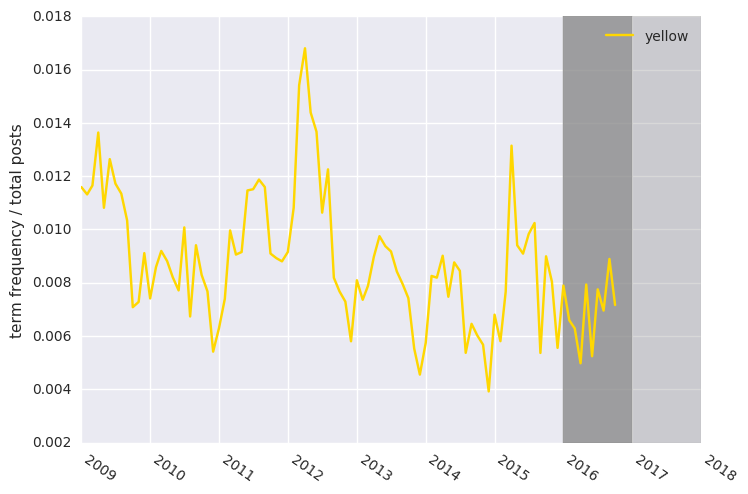

In [77]:
show_plot(2016)

In [123]:
trends_2012 = []
for l in trendy_bg:
    for item in l:
        item_split = item.split('_')
        item = Trend('{} {}'.format(item_split[0], item_split[1]))
        trends_2012.append(item)

In [124]:
top_trends = set([t.phrase for t in trends_2012])

top_trends


{'ankle boots',
 'ankle pants',
 'baggy top',
 'ballet flats',
 'bandage skirt',
 'biker boots',
 'biker vest',
 'bodycon dress',
 'bodycon skirt',
 'boyfriend jeans',
 'cargo pants',
 'chambray shirt',
 'chiffon blouse',
 'chiffon dress',
 'cocktail dress',
 'collar blouse',
 'collar top',
 'collared shirt',
 'coloured jeans',
 'combat boots',
 'comfortable shoes',
 'cowboy boots',
 'crochet shorts',
 'crop top',
 'cropped top',
 'denim cutoffs',
 'denim jeans',
 'denim shirt',
 'denim shorts',
 'denim top',
 'denim vest',
 'dress shirt',
 'dropwaist dress',
 'flared jeans',
 'floral blouse',
 'floral dress',
 'floral jeans',
 'floral pants',
 'floral shorts',
 'floral skirt',
 'floral top',
 'gold heels',
 'graphic tee',
 'harem pants',
 'high heels',
 'highest heels',
 'highlow skirt',
 'highwaisted jeans',
 'highwaisted pants',
 'highwaisted shorts',
 'hm pants',
 'hm trousers',
 'hot pants',
 'hot shorts',
 'jean shorts',
 'knit sweater',
 'knitted top',
 'lace blouse',
 'lace dre

In [125]:
descriptors = []
for item in top_trends:
    item_s = item.split()
    descriptors.append(item_s[0])
count_descriptors = Counter(descriptors)

count_descriptors

Counter({'ankle': 2,
         'baggy': 1,
         'ballet': 1,
         'bandage': 1,
         'biker': 2,
         'bodycon': 2,
         'boyfriend': 1,
         'cargo': 1,
         'chambray': 1,
         'chiffon': 2,
         'cocktail': 1,
         'collar': 2,
         'collared': 1,
         'coloured': 1,
         'combat': 1,
         'comfortable': 1,
         'cowboy': 1,
         'crochet': 1,
         'crop': 1,
         'cropped': 1,
         'denim': 6,
         'dress': 1,
         'dropwaist': 1,
         'flared': 1,
         'floral': 7,
         'gold': 1,
         'graphic': 1,
         'harem': 1,
         'high': 1,
         'highest': 1,
         'highlow': 1,
         'highwaisted': 3,
         'hm': 2,
         'hot': 2,
         'jean': 1,
         'knit': 1,
         'knitted': 1,
         'lace': 6,
         'leather': 5,
         'leopard': 2,
         'lightweight': 1,
         'liquid': 1,
         'long': 1,
         'maxi': 2,
         'midi': 1,
  


from looking at these plots, I want to take a closer look at: long dress, mini dress vs maxi dress, peplum top and any other peplum items, floral (dress, pants, skirt, top, print), tube top vs crop top, ripped jeans vs boyfriend jeans, harem pants

In [126]:

long_dress = Trend("long dress")





In [127]:
long_dress.differences_yr(dfZ, 2009, 2013)

([-0.00017790858044785905,
  -0.00034378148155942654,
  -0.00013262708900512018,
  -8.8758949418601767e-05],
 [('dif 2013 over 2009', -0.34360818456248376),
  ('dif 2013 over 2010', -0.50287009890628553),
  ('dif 2013 over 2011', -0.28070154979353118),
  ('dif 2013 over 2012', -0.20708257755623241)])

In [143]:
interesting_bigrams = ['maxi_dress', 'maxi_skirt', 'maxi', 'peplum_top', 'peplum_dress', 'peplum_skirt',  'peplum', 'crop_top','cropped_top', 'cropped_sweater', 'cropped_blazer'] 

In [144]:
#note to self: make Trendification a function
interesting = []
for item in interesting_bigrams:

    if '_' in item:
        item_split = item.split('_')
        item = Trend('{} {}'.format(item_split[0], item_split[1]))
    else:
        item = Trend('{}'.format(item))
    interesting.append(item)
    

In [145]:
[t.phrase for t in interesting]

['maxi dress',
 'maxi skirt',
 'maxi',
 'peplum top',
 'peplum dress',
 'peplum skirt',
 'peplum',
 'crop top',
 'cropped top',
 'cropped sweater',
 'cropped blazer']

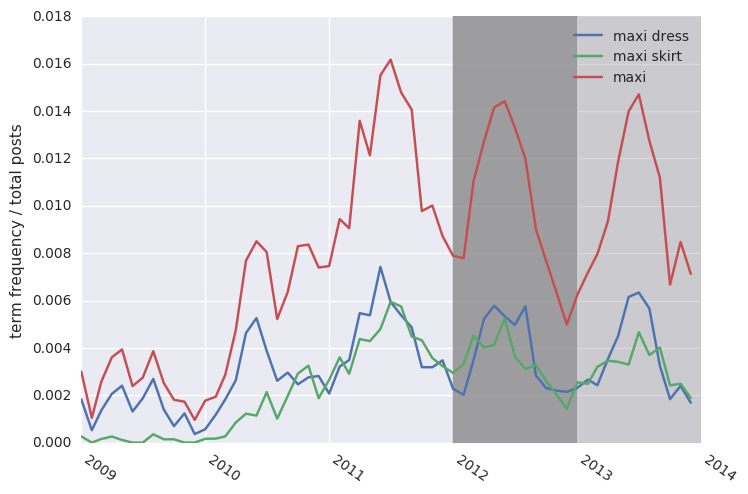

In [146]:
for t in interesting[:3]:
    t.plot_by_month(dfZ, 1, 2009, 60)
show_plot(2012) 

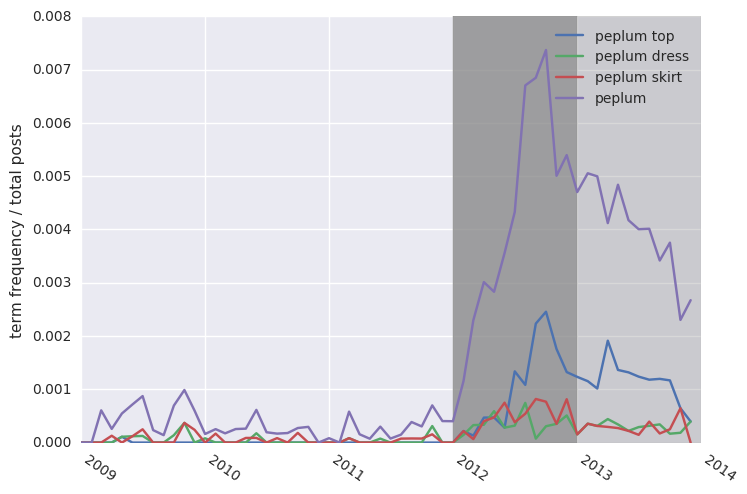

In [147]:
for t in interesting[3:7]:
    
    t.plot_by_month(dfZ, 1, 2009, 60)
show_plot(2012) 

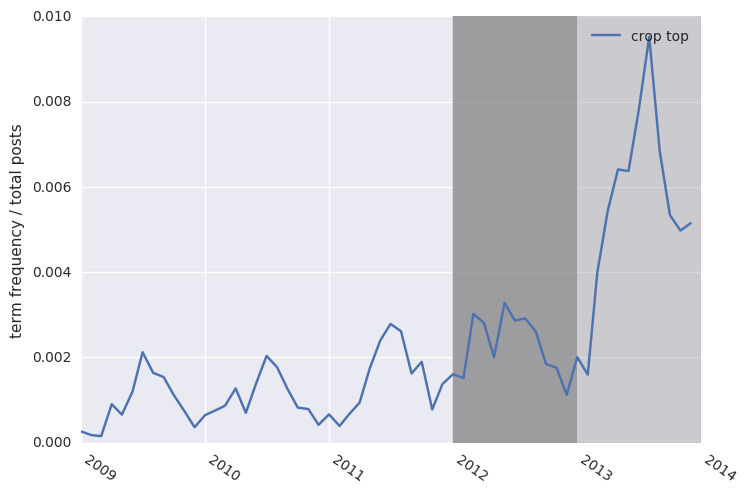

In [150]:

interesting[7].plot_by_month(dfZ, 1, 2009, 60)

show_plot(2012) 

In [83]:
def coerce_to_datetime(series):
    series_2 = []
    for item in series:
        try:
            s = "{}, {}, {}".format(item[0], item[1], item[2])
            series_2.append(s)
        except TypeError:
            series_2.append('2008, 03, 01')
    series_2 = pd.Series(series_2)
    series_3 = pd.to_datetime(series_2)
    return series_3

In [141]:
def get_tf(df, phrase, start_month, start_year, num_months):
    '''
    INPUT: dataframe containing dates and descriptions,
            starting month and year, number of months to search
    OUTPUT: vector as list
    '''
    yr = start_year
    mo = start_month
    tf_by_mo = []
    tp_by_mo = []


    for m in range(num_months):
        print yr
        print mo
#         mask_year = (df.year == yr)
#         df = df[mask_year]
#         mask_month = (df.month == mo)
#         df = df[mask_month]
        if mo % 12 == 0:
            yr += 1
            mo = 1
        else:
            mo += 1
#         df = df.photo_desc
#         total = 0
#         ct = 0
        for row in df.iterrows():
            print row
#     print phrase
#     print "Term freq by month: ", tf_by_mo 
#     print "Total term mentions over this period: ", sum(tf_by_mo)
#     print "proportion of posts using this term, by month: ", np.array(tf_by_mo)/np.array(tp_by_mo)

Just from eyeballing, we can get a sense of items we might want to take a closer look at.

In [ ]:
for line in trendy_bg:
    for item in line:
        item_split = item.split('_')
        get_tf(dfZ, '{} {}'.format(item[0], item[1]), 6, 2008, 24)

2008
6
(0, post_id                                                         5001
photo_desc         \nseaweed scares me\n$3 purse from Garment Dis...
username                                                      olivia
location                                                         NaN
datetime                                         2008-06-15 00:00:00
month                                                              6
quarter                                                            2
year                                                            2008
tokenized_descs    [seaweed, scares, me, 3, purse, from, garment,...
Name: 0, dtype: object)
(1, post_id                                                         5003
photo_desc         \nIm pretty aware that this isnt a photo of wh...
username                                               TheParadodler
location                                                  Apopka, FL
datetime                                         2008-06-15 00:0

In [46]:
class Trend(object):

    def __init__(self, phrase, garment_type=None):
        self.phrase = phrase
        self.type = garment_type


    def plot_over_time(self, df, date_begin, num_weeks):
        '''
        Creates a plot showing the term frequency of the Trend
        over a given date range
        INPUT: dataframe contaiing dates and descriptions,
                start and end date in std format ['1980-01-15']
        OUTPUT: matplotlib object
        '''
        start = pd.to_datetime(date_begin)
        term_frequencies_by_day = []
        total_posts_by_day = []
        tf_by_wk = []
        tp_by_wk = []
        rnges = []

        for week in range(num_weeks):
            rnges.append(pd.date_range(start, start + pd.Timedelta(days=7)))
            start = start + pd.Timedelta(days=7)

        for rng in rnges:


            for a_date in rng:
                mask = df.datetime == a_date
                segment = df[mask]
                segment = segment.photo_desc
                ct = 0
                total = 0
                for row in segment:
                    total += 1
                    if self.phrase in row:
                        ct+=1
                term_frequencies_by_day.append(ct)
                total_posts_by_day.append(total)

            wk_tf = sum(term_frequencies_by_day)
            wk_total = sum(total_posts_by_day)
            tf_by_wk.append(wk_tf)
            tp_by_wk.append(wk_total)

            term_frequencies_by_day = []
            total_posts_by_day = []




        tfw = np.array(tf_by_wk)
        tpw = np.array(tp_by_wk)
        dates_by_week = [rng[0] for rng in rnges]

        data = tfw*1./tpw
        #density = gaussian_kde(data)
        xs = dates_by_week
        #density.covariance_factor = lambda : .25
        #density._compute_covariance()
        #plt.plot(xs,density(xs))


        #plot dates on x axis, frequency on y-axis
        #moving_ave = np.convolve(tfw*1./tpw, np.ones(4)/4)[1:num_weeks+1]
        plt.plot(dates_by_week, tfw*1./tpw, label=self.phrase)






    def plot_by_week(self, df, date_begin, num_weeks):
        '''
        Creates a plot showing the term frequency of the Trend
        over a given date range, by week, using a rolling average over 4 weeks.
        INPUT: dataframe contaiing dates and descriptions,
                start and end date in std format ['1980-01-15']
        OUTPUT: matplotlib object
        '''
        start = pd.to_datetime(date_begin)
        term_frequencies_by_day = []
        total_posts_by_day = []
        tf_by_wk = []
        tp_by_wk = []
        rnges = []

        for week in range(num_weeks):
            rnges.append(pd.date_range(start, start + pd.Timedelta(days=7)))
            start = start + pd.Timedelta(days=7)

        for rng in rnges:


            for a_date in rng:
                mask = df.datetime == a_date
                segment = df[mask]
                segment = segment.photo_desc
                ct = 0
                total = 0
                for row in segment:
                    total += 1
                    if self.phrase in row:
                        ct+=1
                term_frequencies_by_day.append(ct)
                total_posts_by_day.append(total)

            wk_tf = sum(term_frequencies_by_day)
            wk_total = sum(total_posts_by_day)
            tf_by_wk.append(wk_tf)
            tp_by_wk.append(wk_total)

            term_frequencies_by_day = []
            total_posts_by_day = []




        tfw = np.array(tf_by_wk)
        tpw = np.array(tp_by_wk)
        dates_by_week = [rng[0] for rng in rnges]

        data = tfw*1./tpw
        density = gaussian_kde(data)
        xs = dates_by_week
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        plt.plot(xs,density(xs))


        #plot dates on x axis, frequency on y-axis
        #moving_ave = np.convolve(tfw*1./tpw, np.ones(4)/4)[1:num_weeks+1]
        plt.plot(dates_by_week, tfw*1./tpw, label=self.phrase)


    def plot_by_month(self, df, start_month, start_year, num_months):
        '''
        Creates a plot showing the term frequency of the Trend
        over a given date range, by month, (using a rolling average over 3 months).
        INPUT: dataframe contaiing dates and descriptions,
                starting month and year, number of months to plot
        OUTPUT: matplotlib object
        '''
        start_year == str(start_year)
        if len(str(start_month)) == 1:
            start_month = str(0) + str(start_month)
        else:
            start_month = str(start_month)

        start = pd.to_datetime('{}{}01'.format(start_year, start_month))

        term_frequencies_by_day = []
        total_posts_by_day = []
        tf_by_mo = []
        tp_by_mo = []
        rnges = []

        for month in range(num_months):
            #create a list of date ranges, one item for each months
            rnges.append(pd.date_range(start, start + pd.Timedelta(days=30)))
            start = start + pd.Timedelta(days=30)

        #iterate over months
        for rng in rnges:
            #iterate over dates in month
            for a_date in rng:
                mask = df.datetime == a_date
                segment = df[mask]
                segment = segment.photo_desc
                ct = 0
                total = 0
                for row in segment:
                    total += 1
                    if self.phrase in row:
                        ct+=1
                term_frequencies_by_day.append(ct)
                total_posts_by_day.append(total)

            mo_tf = sum(term_frequencies_by_day)
            mo_total = sum(total_posts_by_day) + 1
            tf_by_mo.append(mo_tf)
            tp_by_mo.append(mo_total)
            #reset term frequencies by day
            term_frequencies_by_day = []
            total_posts_by_day = []


        tfm = np.array(tf_by_mo)
        tpm = np.array(tp_by_mo)


        y_axis = tfm*1./tpm
        #density = gaussian_kde(y_axis)
        x_axis = [rng[0] for rng in rnges]
        #density.covariance_factor = lambda : .25
        #density._compute_covariance()
        #plt.plot(xs,density(xs))

        #rolling average. first term mean of months 1 & 2; last (nth) term mean of n-1 & n
        #all others mean of k-1, k, k+1
        #y_axis[0] = np.mean(y_axis[0:1])
        #y_axis[-1] = np.mean(y_axis[-2:-1])
        #y_axis[1:-2] = [np.mean(y_axis[i-1:i+1]) for i in range(len(y_axis[1:-2]))]

        #plot dates on x axis, frequency on y-axis
        #moving_ave = np.convolve(tfw*1./tpw, np.ones(4)/4)[1:num_weeks+1]
        print tfm

        plt.plot(x_axis, y_axis, label=self.phrase)
        return tfm
    

In [128]:
dfZ.year

0        2008
1        2008
2        2008
3        2008
4        2008
5        2008
6        2008
7        2008
8        2008
9        2008
10       2008
11       2008
12       2008
13       2008
14       2008
15       2008
16       2008
17       2008
18       2008
19       2008
20       2008
21       2008
22       2008
23       2008
24       2008
25       2008
26       2008
27       2008
28       2008
29       2008
         ... 
37133    2012
37134    2012
37135    2012
37136    2012
37138    2012
37139    2012
37140    2012
37143    2012
37144    2012
37146    2012
37147    2012
37148    2012
37149    2012
37150    2012
37151    2012
37153    2012
37154    2012
37156    2012
37157    2012
37158    2012
37159    2012
37160    2012
37161    2012
37162    2012
37163    2012
37164    2012
37166    2012
37167    2012
37168    2012
37169    2012
Name: year, dtype: int64

In [22]:
tokens = df2009.tokenized_descs

In [23]:
tokens

8486    [fabulous, outfit, to, ring, in, the, fabulous...
8487                                 [playing, dress, up]
8488    [off, to, see, my, friends, today, and, to, co...
8489                 [vacayappropriate, attire, i, enjoy]
8490    [christmas, is, for, shoes, 3, happy, new, yea...
8491                                                   []
8492                                                   []
8493    [a, very, late, post, i, know, with, me, in, t...
8494                                              [muahh]
8495    [taken, during, our, team, photoshoot, great, ...
8496    [goodbye, 2008, hello, 2009, as, we, welcome, ...
8497    [another, side, of, me, i, guess, its, classy,...
8498    [ps, a, very, very, veryyy, happy, new, year, ...
8499    [december, 31, 2008, january, 1, 2009, nye, in...
8501                                 [i, am, going, loco]
8502    [the, fabric, is, a, shiny, matte, and, my, ph...
8503    [i, admit, iam, too, lazy, to, sew, and, been,...
8504          

In [26]:
def bigrams_colloc(tokens):
    finder = nltk.BigramCollocationFinder.from_words(tokens)
    bigram_measure = nltk.collocations.BigramAssocMeasures()
    return finder, bigram_measure

def bigrams_standard(tokens):
    bigrams = nltk.bigrams(tokens)
    fdist = nltk.FreqDist(bigrams)
    return bigrams, fdist
    

In [28]:
dress = Trend("dress")
pants = Trend("pants")
shoes = Trend("shoes")

In [29]:
def six_mo_plot(df, year, start_q, term):
    q1 = quarter_dfs['{}_q{}'.format(year, start_q)]
    if start_q == 4:
        q2 = quarter_dfs['{}_q{}'.format(year + 1, 1)]
    else:
        q2 = quarter_dfs['{}_q{}'.format(year, start_q + 1)]

    df_this = pd.concat([q1, q2])
    
    tokens = tokenize(df_this)
    finder, bigram_measure = bigrams_colloc(tokens)
    
    top_freq = []
    while len(top_freq) < 10:
        for phrase in finder.nbest(bigram_measure.raw_freq, 100000):
            if str(phrase[1]) == term and str(phrase[0]) not in nltk_sw:
                top_freq.append(phrase)      
        
    for ind in range(10):
        this_trend = top_freq[ind]
        this_trend = "{} {}".format(this_trend[0], this_trend[1])
        this_trend_ob = Trend(this_trend)

        print this_trend_ob.phrase

        this_trend_ob.plot_over_time(df, '2008-06-30', 156)
        plt.legend()
        plt.xticks(rotation=35)
        plt.axvspan(df_this.datetime.min(), df_this.datetime.max(), color='red', alpha=0.3)
        plt.show()

        
    

[ 698  795  900  965 1078 1489 1529 1014 1048 1384 1483 1504 1434 1481 1244
 1032 1330 1382 1818 2156 1946 2136 2089 2153 2096 2129 1848 1764 1489 1461
 1633 1687 1562 1594 1760 1994 2172 2662 4122 3946 3571 1898 1901 3368 3893
 4403 3030  551 2205 2222 1869 1577 1384 1109 1012 1241 1187 1307 1437 1782] [ 3399  3898  4768  5630  6316  9429  9163  6570  6429  7899  9135  8547
  8010  8569  7801  6985  8191  8240 11123 13247 11819 12201 11460 11609
 10922 11436 11539 11480 10746  9752 10829 11728 11900 12336 13829 13974
 13240 15792 26123 26371 24704 13443 13391 26176 29805 31477 21929  3761
 15659 15749 14575 13786 12621 11684  9931 13114 12748 12932 13998 15086]
bigone!


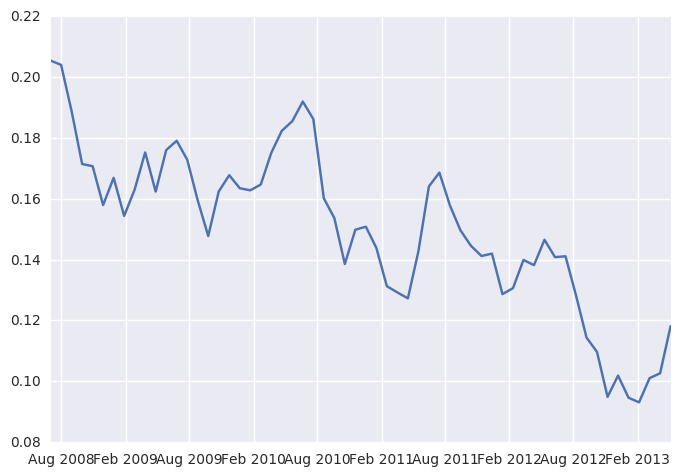

In [30]:
dress.plot_by_month(dfY, 7, 2008, 60)
plt.show()

[  9  16  14  14  11  21  22  10  14  29  40  19  21  31  21  15  14   8
  22  24  25  55  74 102  96  69  61  98  82  78  75 111 109 143 165 201
 213 240 380 328 236 128 112 203 285 350 268  64 234 196 163 120  90  72
  49  81 106 102 127 197] [ 3399  3898  4768  5630  6316  9429  9163  6570  6429  7899  9135  8547
  8010  8569  7801  6985  8191  8240 11123 13247 11819 12201 11460 11609
 10922 11436 11539 11480 10746  9752 10829 11728 11900 12336 13829 13974
 13240 15792 26123 26371 24704 13443 13391 26176 29805 31477 21929  3761
 15659 15749 14575 13786 12621 11684  9931 13114 12748 12932 13998 15086]
bigone!
[  5   8   9   4   7  12  15   5   8  14  26  11  13  23  12   7   9   5
   7  13  15  34  41  70  43  40  25  38  25  27  26  34  39  59  62  94
  99  82 128 124  72  47  37  45  80 138 105  25  90  85  66  34  25  29
  21  29  36  37  44  74] [ 3399  3898  4768  5630  6316  9429  9163  6570  6429  7899  9135  8547
  8010  8569  7801  6985  8191  8240 11123 13247 11819 12201 11

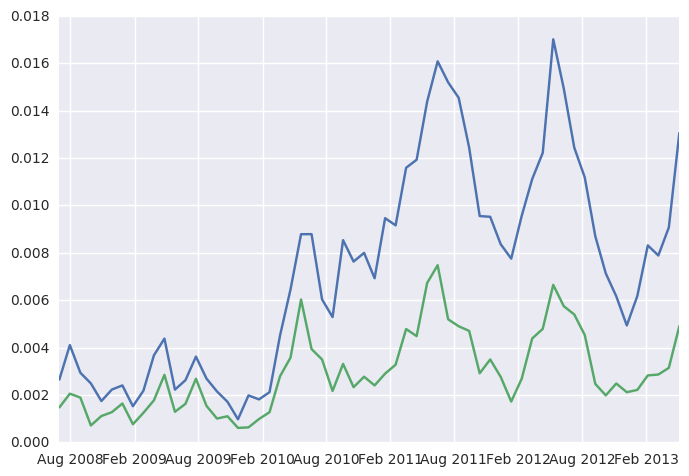

In [31]:
maxi = Trend("maxi")
maxi.plot_by_month(dfY, 7, 2008, 60)
maxi_dress = Trend("maxi dress")
maxi_dress.plot_by_month(dfY, 7, 2008, 60)
plt.show()


In [47]:
blah_words = ["nice", "pretty", "fantastic", "new", "little", "red", "another", "favorite"]

In [33]:
model.most_similar("dress")


[('skirt', 0.7811539173126221),
 ('romper', 0.7308602929115295),
 ('blouse', 0.7268615961074829),
 ('jumpsuit', 0.6905241012573242),
 ('tunic', 0.6581505537033081),
 ('top', 0.6380647420883179),
 ('blazer', 0.622455358505249),
 ('jumper', 0.5938715934753418),
 ('sweater', 0.5870984792709351),
 ('cardigan', 0.5706201791763306)]

In [34]:
def manual_stopwords(boring_words, model):
    sw = []
    for word in boring_words:
        sw.append(collect_similar(word, model, 10))
    return set([item for l in sw for item in l])


In [35]:
man_sw = manual_stopwords(blah_words, model)

In [36]:
man_sw

{'ago',
 'also',
 'amazing',
 'awesome',
 'beautiful',
 'big',
 'bit',
 'cool',
 'current',
 'cute',
 'difficult',
 'ebay',
 'fabulous',
 'fantastic',
 'favourite',
 'finally',
 'girly',
 'good',
 'gorgeous',
 'great',
 'incredible',
 'incredibly',
 'kinda',
 'latest',
 'lil',
 'little',
 'lot',
 'lovely',
 'new',
 'newest',
 'nice',
 'own',
 'perfect',
 'pretty',
 'quite',
 'recently',
 'slightly',
 'so',
 'soo',
 'sooo',
 'soooo',
 'spectacular',
 'stunning',
 'super',
 'tad',
 'tiny',
 'too',
 'very',
 'wee',
 'wonderful'}

In [37]:
all_sw = list(nltk_stopwords) + list(man_sw)

In [38]:
all_tokens = dfZ.tokenized_descs

In [ ]:
#bigrams = bigrams_for_all_garments(all_tokens, model, all_sw)

In [40]:
bigrams2009 = bigrams_for_all_garments(df2009.tokenized_descs, model, all_sw)

In [41]:
model_bg_2009 = Word2Vec(bigrams2009)

In [42]:
def get_bigrams(model, term):
    bigrams = []
    bigrams_split = []
    
    for item in model.most_similar(term, topn=10000):
        if '_'.format(term) in item[0]:
            item_split = item[0].split('_')
            bigrams.append(item[0])
            bigrams_split.append('{} {}'.format(item_split[0], item_split[1]))

    return bigrams, bigrams_split


In [43]:
dress_bg_2009 = get_bigrams(model_bg_2009, "dress")

In [44]:
top_100 = dress_bg_2009[0][:100]

another_dress
[ 2  0  0  2  4  1  5  5  3  3  4  2  3  4  5  2  2  0  8  3  6  1  2  7 11
 12  4  2  1  1  4  1  2  6  6  2  5  3  2  6  2  4  2  5  7  4  2  5]
maxi_dress
[  1   5   8   9   4   7  12  15   5   8  14  26  11  13  23  12   7   9
   5   7  13  15  34  41  70  43  40  25  38  25  27  26  34  39  59  62
  94  99  82 128 124  72  47  37  45  80 138 105]


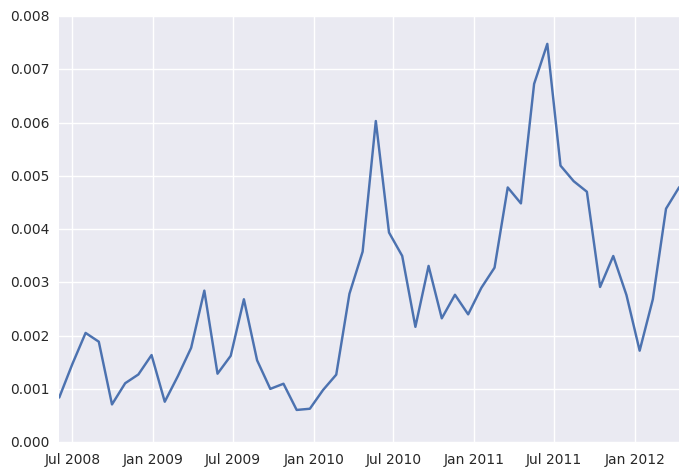

tunic_top
[0 1 1 2 2 0 0 2 2 1 0 4 0 3 2 1 2 1 0 1 7 6 1 2 3 3 2 4 4 1 2 1 2 3 2 1 6
 0 0 2 6 0 3 2 1 6 4 0]
vintage_dress
[ 3 19 16 18 22 27  6 35 20 21 23 28 28 24 27 27 13 28 23 32 23 39 29 21 25
 31 28 22 37 25 22 23 40 23 23 33 44 43 70 54 92 53 32 42 83 88 73 56]


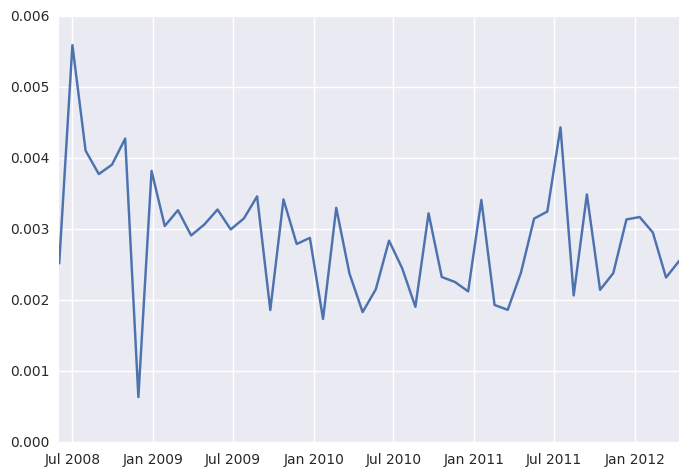

simple_top
[ 0  1  0  0  0  1  4  0  0  0  1  0  0  0  1  1  1  1  3  1  2  1  1  2  4
  3  4  5  3  2  1  0  1  3  2  4  3  2 11 12  4  2  6  3  3 10  8  2]
first_dress
[ 2  0  0  0  1  1  0  8  0  0  1  0  1  5  1  4  0  3  1  2  2  2  2  1  4
  4  3  3  1  2  3  1  2  1  3  1  0  5  2  8 16  0  2  1  3  0  2  3]
black_dress
[ 7 10 14 18 23 23 52 49 28 26 33 27 27 22 35 25 22 37 42 42 33 37 31 37 27
 33 33 27 25 25 19 25 33 31 25 20 41 25 39 68 76 74 45 38 59 86 96 54]


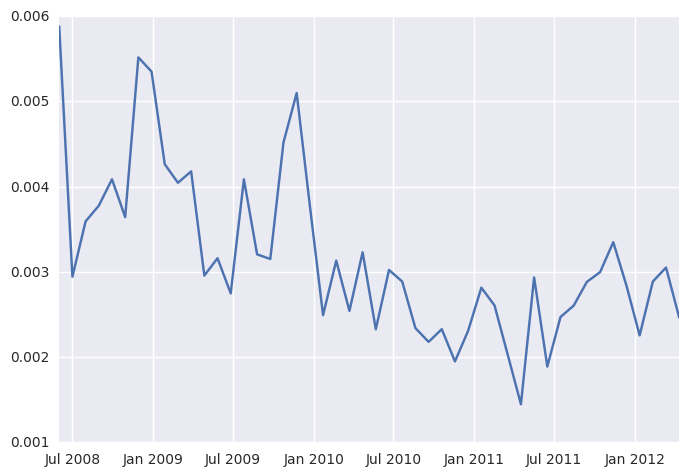

satin_blouse
[0 1 0 0 1 1 0 0 1 0 2 1 0 0 0 0 0 1 0 0 0 0 0 0 0 2 0 0 1 1 0 0 0 0 0 0 1
 0 1 0 0 0 0 0 4 0 2 0]
summer_dress
[ 2  7  5  4  9  7 16  5 12 16 21 23 18 15 15 18 12  8  8  9 17 16 21 40 48
 38 21 20 18 12 14 13 17 17 15 14 32 37 42 72 64 43 19 10 35 36 42 36]


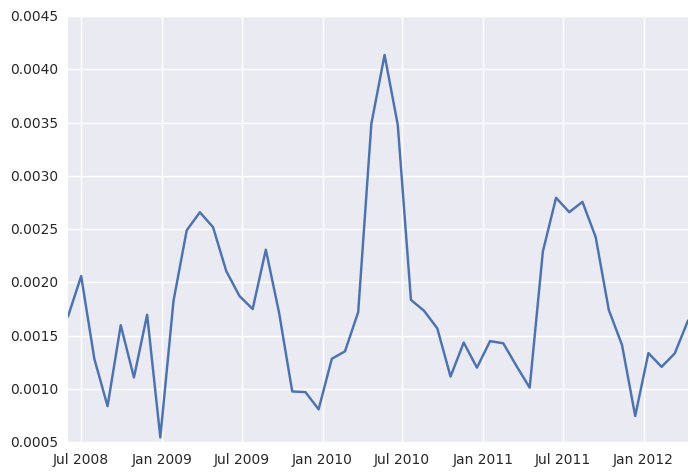

white_dress
[ 3  5  5  5  8  9 12 18  9 10 11 17 16 17 12 12 10 13 11 11 16 12 13 17 18
 23 17 19 11  8  8 10 10 14  9  9 23 16 23 48 34 13  9 14 24 44 40 15]


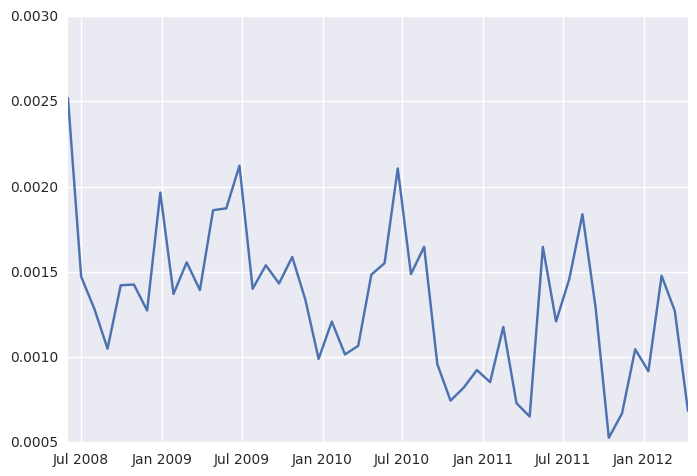

didnt_dress
[0 0 0 0 0 1 3 1 0 0 1 0 1 1 0 0 1 1 1 1 4 0 3 1 1 0 0 1 0 2 1 1 0 0 1 0 0
 1 0 4 2 4 1 0 0 0 0 0]
favorite_blouse
[ 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  1  1  1  1  0  1  1  0  0  0
  3  2  3  3  0  0  0  1  4  1  1  1  1  6  2 14  6  1  3  8  6  4  2]
favorite_dress
[ 1  8  5  2  8  3  8 11  7  7  7 29 11 14 15  9 10 14  9 15 27 13 12 16 13
 29 22 15 13 14 14 23 18 15  6 14 12 21 24 36 38 35 21 16 18 40 40 28]


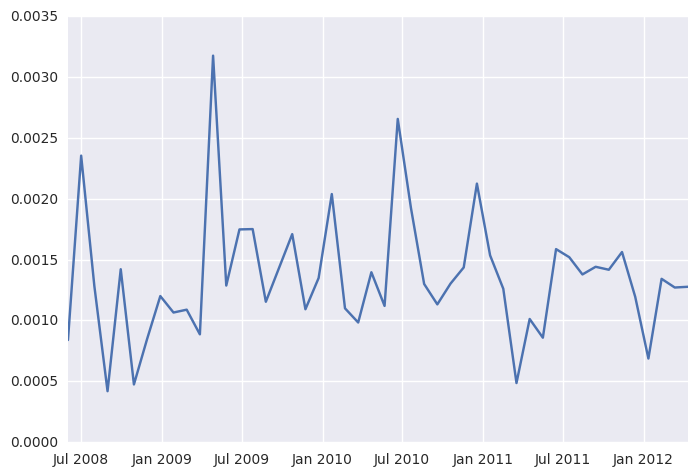

tee_shirt
[ 1  4  1  1  2  2  2  5  0  4  3  6  2  4  7  7  2  5  2  9 13 16 10  6  4
  8  4  5  3  3  2  1  5  1  4  4  7  3  8 14  8  5  4  4 21 14 16  0]
bfs_shirt
[0 0 0 0 0 0 0 1 0 0 1 3 1 2 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0]
usually_dress
[0 0 1 0 0 1 6 1 0 0 0 1 1 1 1 2 2 0 2 3 4 3 3 0 2 1 4 6 4 2 2 1 6 5 1 4 3
 3 1 4 2 4 1 2 6 8 4 2]
sweater_dress
[ 0  2  0  5  6 11  9 14 11  6  5  7  0  4  3  3  9 19 16 13 14 11  4  3  1
  0  5  5  8  9 20 14  6 10  8  1  2  3  1  4 16 36 18 13 31 25 14 10]
red_dress
[ 1  9  3 13 10  8 23 10  8  8 14 21 17 16 16 16  8 14 16 12 22 10 14 19 20
 15 28 15 11 10 23 23 14 18 20 21 19 19 24 44 38 55 29 30 60 57 55 51]


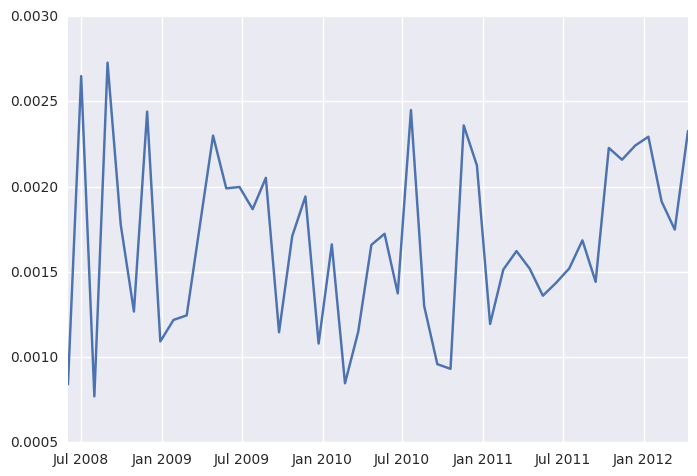

dont_dress
[0 0 1 0 1 2 0 6 1 0 2 1 1 0 2 4 3 4 1 2 4 2 3 3 3 0 5 2 1 0 0 1 5 1 2 1 2
 3 2 2 0 6 3 2 4 0 0 2]
really_dress
[0 1 3 1 0 2 3 4 1 3 2 2 0 1 1 0 3 1 6 7 7 5 2 1 2 3 4 4 3 1 3 6 4 1 2 2 3
 3 2 4 2 7 3 4 5 0 4 2]
play_dress
[ 2  2  1  0  1  5  1  7  6  3  5  5  3  4  7  3  1  6  5  3  4 14  7  6  8
  5  3  6  5  5  1  3  4  2  3  3  6  5  4 16  6  3  2  3 11 10 12  6]
short_skirt
[ 0  3  0  6  4  5  9  4  5  3  2  0  5  3  2  4  3  9  5  6  6  9 10  9  5
  7  4  7  9  6  2  4  3  9  4  4  3  7  6  8 22  4  5  4 16 16 24  5]
formal_dress
[ 0  0  0  0  1  1  5  1  2  1  1  0  4  3  1  1  1  0  1  0  3  0  3  1  3
  1  2  2  0  2  1  0  0  0  0  4  5  3  4  2  6 10  2  3  4  4 16  2]
old_dress
[ 0  3  2  1  3  6 10  9  3  6  6  4  9  6  7  6  4  6  5  9  4  5  6  3  9
  7  5  7  3  2  5  4  5  8  5  6  4  5  7 16 14 18  4  3 10 12 16 11]
would_dress
[0 0 0 1 1 4 0 1 2 1 4 1 0 1 2 1 2 3 3 2 1 3 1 3 4 3 1 2 2 2 2 0 2 1 1 3 2
 1 0 0 6 1 1 1 2 0 0 4]
played_dress
[0 0 0 1 1 1 2 0 0 1

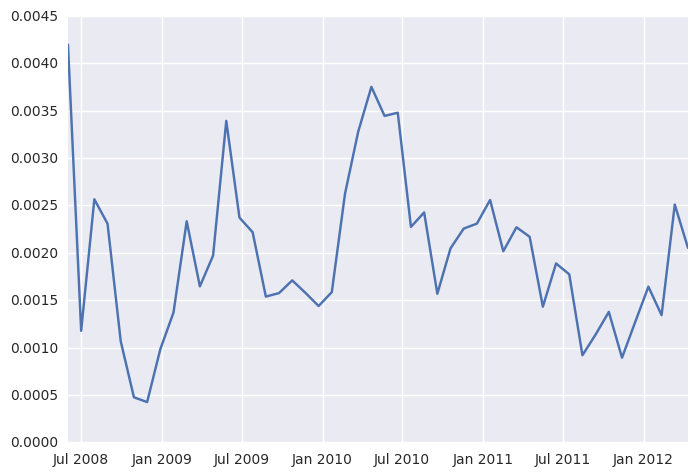

yellow_dress
[ 4  5  4  3  1  0  3  6  2  3  3  3  7  7  3  3  2  1  2  3  3  4  3  6  3
  4  4  2  0  2  0  0  1  2  3  7  4  4  8 20  8  0  5  3 10  4 12 18]
long_dress
[ 0  1  2  2  7  1  0  4  1  1  4  7  3  4  8  3  3  6  2  7  7  7  9  9  7
  6  6 13 13  5  8  4  3  4  5  6 10  9 15 12  8  6  6  4  8 16 10 19]
prom_dress
[ 2  2  1  1  7  4  3  3  2  7 13  6 11  5  6  4  4  8  3  7  4  4 13  8  7
 11  8  7  5  0  3  4  3  3  5  5 10 10  5  4  0 19  1  8 12 15 16 14]
long_skirt
[ 0  2  2  2  2  5  2  2  7  3  7  7  4  2  3  2  3  5  5  2  6  6  4  7 15
 17  9 16 17 11 17  7 15 19 20  8 22 18 15 36 26 39 18 11 18 18 38 21]


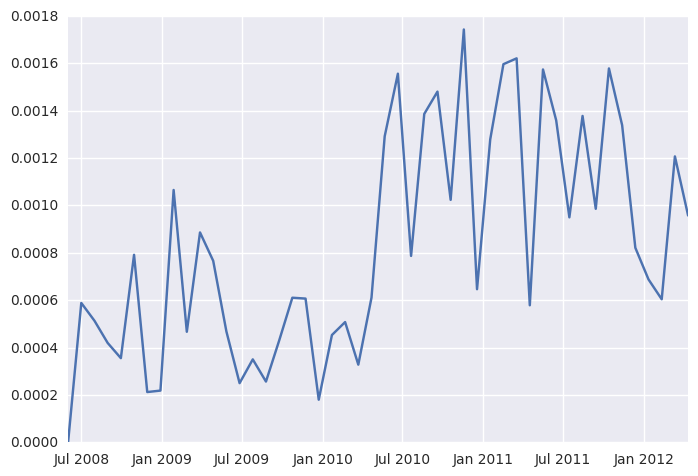

whole_dress
[0 0 0 0 0 0 0 0 0 1 0 2 2 0 3 2 0 0 1 1 2 2 4 0 0 3 1 1 1 0 0 0 0 0 1 1 1
 2 3 2 2 2 0 2 1 0 2 4]
tube_top
[ 3  8  5 10 10  8 25 16  8 12 21 19 20 12 19 12  8 11  7  6  9  7 16  6 12
 18 11 12 11  6  4  3  4  7  7  4  7 13 14 16 12  6  2  4 11  4  6  4]
wear_jeans
[ 0  4  1  3  4  2  4  7  5  1  4  4  4  5  6  3  3  7  8 17 19 14 19 10 15
  9 13 14  8  9  3  9  3 14  8 10  9  8  7 18 10 17  4 10 10 14 26  6]
frilly_dress
[0 0 0 0 0 0 0 1 2 1 0 0 0 0 2 0 1 0 1 0 0 3 0 1 0 1 0 2 0 1 1 1 0 3 4 0 0
 2 1 2 0 0 0 0 0 0 0 2]
chic_dress
[ 0  0  1  0  1  0  0  0  0  0  1  2  2  0  1  1  0  1  1  1  0  0  2  1  0
  0  2  2  1  3  1  1  2  1  1  0  1  4  2  4  2  5  1  2  4 12  2  1]
batik_dress
[0 0 1 0 0 0 0 0 0 0 2 3 1 0 1 2 0 2 1 0 0 1 1 1 2 0 1 2 0 1 0 0 0 1 0 1 0
 1 0 0 0 1 1 1 0 0 0 0]
length_skirt
[ 1  1  0  1  0  1  4  1  3  2  2  0  2  3  1  1  1  1  2  2  2  2  7  3  6
  1  4  6  9  5  4  4  8 13  6  4  3  5  8 10 26 13 12  3 10 17  6  3]
always_dress
[ 0  1  0  1  1  2  0

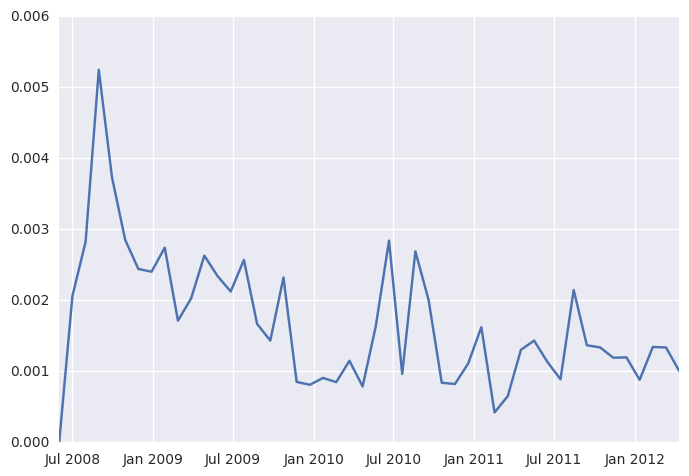

harem_pants
[ 0  2  2  3  6 11 10  8 11 19 21 29 14 28 12 14 11 20  6 18 17 18 16 21 16
 18 21 21 15 11 17 20 18 13 13 11 17 11 13 24 22 13  8  3 20  3 16 12]


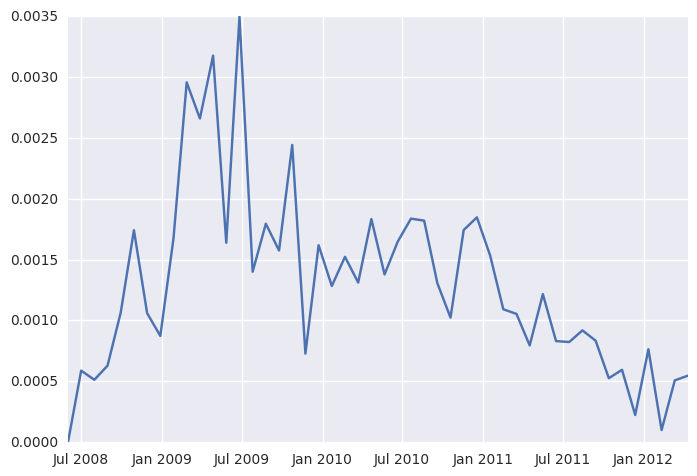

baggy_jeans
[0 0 0 2 1 1 0 1 2 2 2 0 0 1 0 2 2 2 0 0 0 1 1 0 0 0 3 4 0 2 0 0 0 0 0 1 2
 1 0 2 0 2 0 1 0 2 2 1]
wear_heels
[ 3  4  9  7  8  8  7  8  8  6  5 10 12  9  6  4  2  9  9 15 22 15 11 10 16
 23 19 16 11 13 12 12 10 15  9  7  6 15 12 12 12 13  5 10 12 18 16 15]


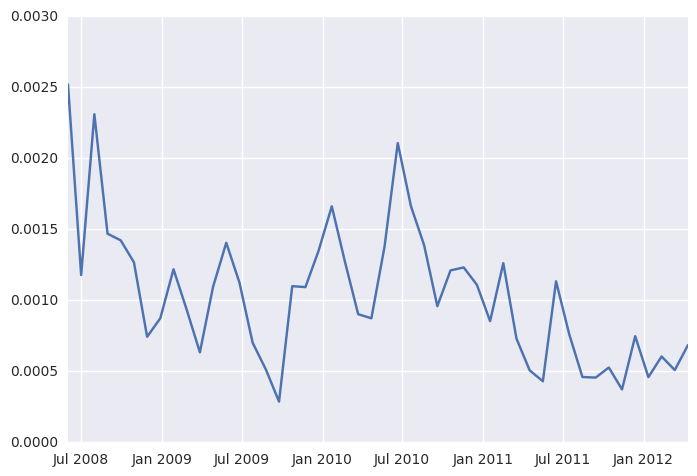

brothers_glasses
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
loose_top
[ 0  0  0  1  1  2  6  5  3  1  3  6  2  7  2  7  3  4  3  4  3  3  3  5  7
  4 10  9  5  5  8  2  5  2  6  4  5  7  5 20  8  4  3  2 10  0  8  4]
white_blazer
[ 2  0  0  3  0  3  4  1  0  1  4  9  5  7  8  5  2  3  4  0  2  4  5  3  3
  7  2  3  2  2  3  4  4  5 10  2  4  4 12 16 12  6  4  5  4 28 20 18]
chiffon_top
[ 0  0  1  2  2  1  3  0  0  0  0  4  1  0  1  1  1  1  0  0  2  1  1  0  2
  2  1  4  0  3  2  0  2  3  3  0  1  2  3  6  8  2  5  1 14  4  6  1]
sexy_dress
[0 0 0 0 0 0 4 2 1 0 0 1 1 1 1 0 2 3 0 0 2 0 1 3 0 0 1 0 0 0 2 0 2 3 2 0 0
 0 1 2 4 4 1 3 2 4 6 3]
tube_dress
[ 3  9  5  9  4 16 12  5  9  8  5 10 12  9 10  9  8 10  6  8  9  7  8  7  3
  9  6  3  3  3  5  8  4  3  1  5  1  3 16 10  6 12  4  5  8  4  8  8]
plain_tshirt
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 2 0 0 0]
tank_top
[  8  23  15  28  3

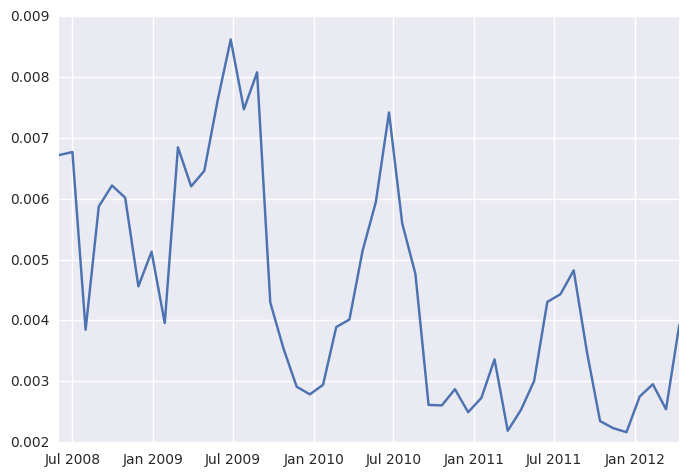

aa_dress
[0 2 0 3 1 0 0 2 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0]
another_top
[0 1 0 0 0 3 0 0 1 1 1 0 0 1 1 1 1 0 3 0 1 3 1 2 1 0 0 1 1 0 0 1 0 2 1 0 0
 2 5 2 0 4 0 1 0 0 0 2]
moms_dress
[0 0 0 1 1 0 1 3 2 0 1 3 3 1 0 1 0 1 1 1 1 0 0 3 1 1 0 2 0 0 0 0 1 1 2 1 0
 4 0 0 2 2 1 0 2 0 0 1]
red_top
[ 0  4  2  5  6  6  5  5  2 10  7  2  3  6 10  2  1  7  4  7  9  5 10  6  6
 13 11  4  8  4  5  8  4  8  7  6  6  6 12 14 18 20  8 12 13 14 18 22]
elegant_dress
[0 0 0 0 0 0 0 0 1 0 0 1 0 2 1 0 0 0 1 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 3 1 1
 1 1 2 4 4 4 2 1 8 2 3]
purple_sweater
[0 1 0 1 0 0 1 9 1 0 0 0 2 0 2 1 0 0 1 2 4 2 1 1 1 1 1 0 1 0 2 1 2 0 0 0 0
 0 0 0 2 5 2 1 0 4 0 1]
lace_dress
[ 1  2  5  4  2 11 19 13  8  7  5  8  7  2  8  5  4  7  7 15 17 11 10 10 14
 15 23 17 12 16 16 24 15 23 11 16 20 19 28 52 34 47 20 28 40 25 32 35]


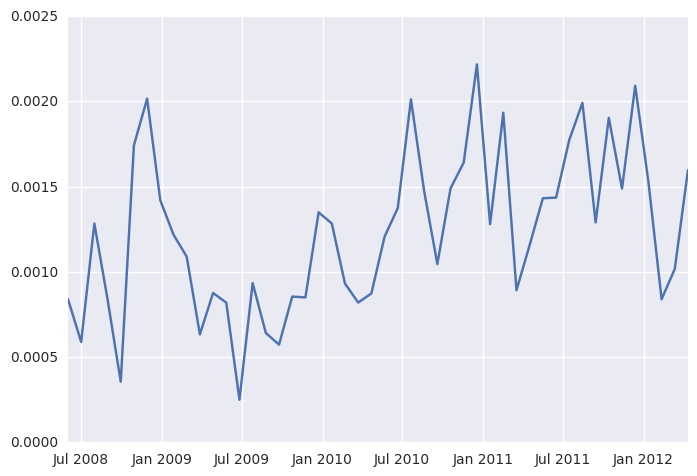

pleather_pants
[0 0 0 0 0 0 0 2 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0
 0 0 2 0 2 0 2 0 0 2 1]
strapless_dress
[ 0  2  1  0  3  0  3  2  2  1  8  5  6  3  6  3  5  3  6  6  4  3  4  5  8
 15  7  2  3  4  3  6  3  4  2  2  7 11 12 16  6  9  4  1 10 12 12  7]
red_vest
[0 0 0 1 0 0 1 0 1 0 1 3 2 3 3 1 4 1 1 2 1 1 0 1 1 0 3 4 0 2 0 0 1 0 1 0 2
 1 1 6 0 4 0 2 0 0 4 0]
comfortable_shirt
[0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 2 1 1 1 0 2 1 0 0 0 0 1 0 0 0 2 1 2 0 0 0 1
 0 0 0 4 4 0 0 0 0 2 1]
purple_top
[0 0 1 3 3 2 2 3 3 4 2 4 3 8 3 1 0 1 2 1 2 2 0 4 2 1 3 1 4 1 2 0 2 0 0 0 2
 1 3 2 2 0 0 0 0 4 4 0]
brown_blazer
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 3 3 0 0 1 0 0 3 0 0 0 0 0 0 2 1 0 0 1 0 0 0 0
 0 0 4 2 0 2 0 0 2 0 0]
grey_jumper
[0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0
 0 1 2 0 0 1 1 0 4 2 1]
feather_skirt
[0 0 0 1 1 0 0 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1 0 0 1 0 0 0 2 0 0 0
 0 0 0 0 0 0 0 0 2 0 2]
ripped_leggings
[0 0 0 0 0 0 0 1 0 0 0 1 0 1 2 2 0 0

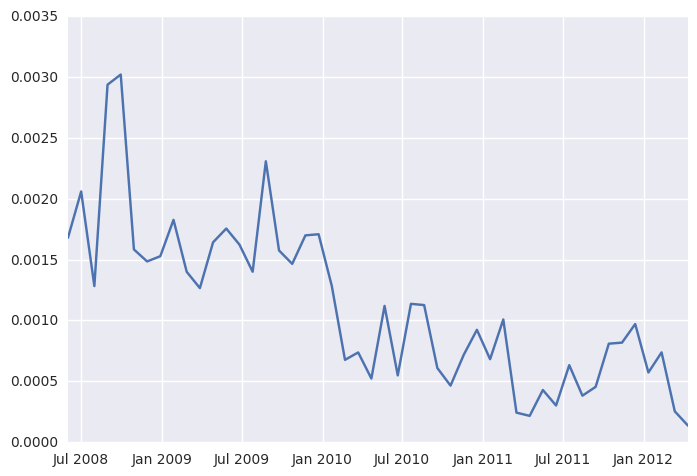

wear_shorts
[ 3  4  2  4  2  2  2  3  2  3  6  3  8  4  7  6  3  4  6  6 10 10 18 25 19
 18 14 15 12 11  6  9  8 17  9 15 20 13 18 24 32 15  7 10 24 20 22 18]


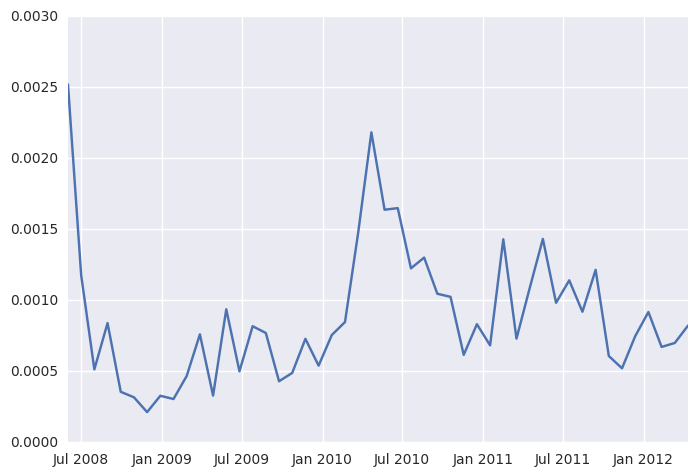

In [48]:

for bigram in top_100:
    print bigram
    item_split = bigram.split('_')
    bigram = Trend('{} {}'.format(item_split[0], item_split[1]))
    tfm = bigram.plot_by_month(dfY, 6, 2008, 48)
    if sum(tfm) > 500:
        plt.show()
    else:
        plt.close()

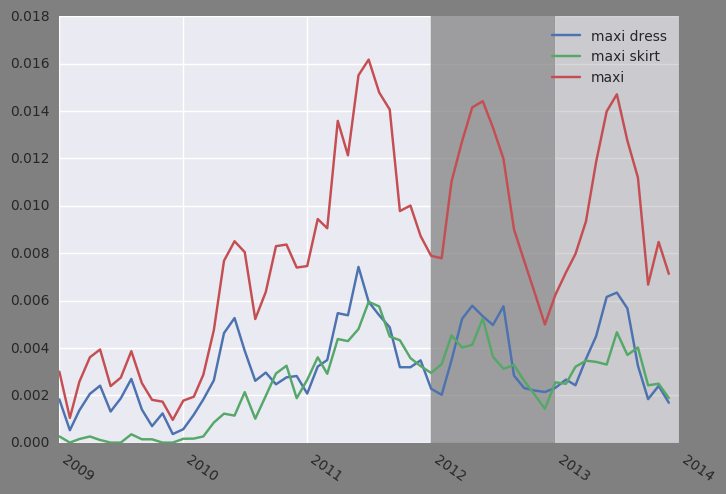

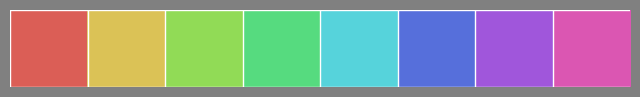

In [90]:
maxi_dress = Trend("maxi dress")
maxi_dress.plot_by_month(dfZ, 1, 2009, 60)
maxi_skirt = Trend("maxi skirt")
maxi_skirt.plot_by_month(dfZ, 1, 2009, 60)
maxi = Trend("maxi")
maxi.plot_by_month(dfZ, 1, 2009, 60)
    
show_plot(2012)